## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2023.

## Assignment 2 - Task 2: Regularizations

In this task, you are going to experiment with two popular regularization techniques. 

**Batch normalization:**

When a network becomes deeper, the distribution of the parameters from hidden neurons will also shift greatly. This is one of the reasons that makes it difficult to train a deep neural network.

Machine learning teaches us that normalization is a good preprocessing method to deal with such a problem. Therefore, batch normalization deploys a similar idea in neural networks by re-normalizing the hidden values of each layer's outputs before transfering them to the next layer.

**Dropout:**

In the last assignment, you trained a shallow network and everything looked fine. However, when the network becomes whider and deeper, one of the immediate problems you will be encountering is overfitting. The network overreacts to noise or random errors of the training data while failing to detect the underlying distribution and generalize poorly on the vaidation/test set.

Dropout is a well-known method that can mitigate such effects. The core idea behind it is quite simple: rather than updating all trainable parameters each time, it randomly selects a subset of parameters to update and keeps other parameters unaltered.

**References:**
* https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
* https://arxiv.org/pdf/1502.03167.pdf
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
* https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, val = fashion_mnist.load_data()

X_train_raw, y_train = train
X_val_raw, y_val = val

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_val = X_val_raw.reshape((X_val_raw.shape[0], X_val_raw.shape[1]**2))

mean_image = np.mean(X_train, axis=0).astype(np.float32)
X_train = X_train.astype(np.float32) - mean_image
X_val = X_val.astype(np.float32) - mean_image

# We've vectorized the data for you. That is, we flatten the 32×32×3 images into 1×3072 Numpy arrays.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Training data shape:  (60000, 784)
Training labels shape:  (60000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)


## Part 1: Batch Normalization (10%)

### Intuition

When training a neural network, different network layers may prefer different distribution of the input to function more effectively. However, inputs often come in varying ranges due to the fact that:
- Data are often batched in vairous ways, so the statistics of every batch does not always reflect the statistics of the whole input space;
- Due to network training, the outputs of preceding layers constantly change even on the same data.

Batch normalization propose to address this by inserting an independent layer that transforms the preceding outputs to a **learnable** distribution before sending them as input to the layers after. Specifically, our goals are:
1. Obtain a good **estimate** of the mean and variance of the entire input space.
2. Use this quantity to **standardize** the input distribution to $0$ mean and unit variance.
3. **Learn** an appropriate output mean and variance that the input should be transformed into.

Particularly, let

$$X_b = (x_1, \dots, x_N)^T \in R^{N \times D}, \quad x_i \in R^D$$

be some batched input data with batch size $N$ where $b$ is the batch index (e.g. $X_1$ denotes the $1$-st batch).

Batch normalization translates to two steps:
1. Standardization:
   $$
   \hat{X}_b = \frac{X_b - \hat\mu}{\sqrt{\hat\sigma^2 + \epsilon}} = \begin{bmatrix}
   \frac{x_1 - \hat\mu}{\sqrt{\hat\sigma^2 + \epsilon}}, \cdots,
   \frac{x_N - \hat\mu}{\sqrt{\hat\sigma^2 + \epsilon}}
   \end{bmatrix}^T \in R^{N \times D}
   $$
   where $\hat\mu, \hat\sigma^2 \in R^D$ are the estimated mean and variance of the input space (see below).
2. Transformation:
   $$
   Y_b = \hat{X}_b \odot \gamma + \beta = \begin{bmatrix}
   \hat{x}_1 \odot \gamma + \beta, \cdots,
   \hat{x}_N \odot \gamma + \beta
   \end{bmatrix}^T \in R^{N \times D} \in R^{N \times D}
   $$
   where $\beta, \gamma \in R^D$ are **learnable** parameters of desired output mean and vairance.

<span style="color:red"><strong>Note:</strong></span> In the left equalities of the two formulas above, the notations are chosen for simplicity consideration. As is shown by the right equalities, batch normalization is applied to **every sample** in the batch $X_b$, so the computation simply propagates through the batch dimension.

<span style="color:red"><strong>Hint:</strong></span> You can also code in this fashion with the help of [broadcasting mechanism](https://numpy.org/doc/stable/user/basics.broadcasting.html).

Now, let's take a closer look at what happens in the training and testing stage respectively.

### Training Stage

Observing from the above equations, batchnorm is a **parametrized** layer (by $\hat\mu, \hat\sigma^2, \beta, \gamma$). Particularly, $\beta, \gamma$ are learned through network optimization (e.g. via gradient descent). One piece of the missing puzzle is the calculation of $\hat\mu, \hat\sigma^2$.

In the world of model training, we often live with the following assumptions:
- Training data represents a good and unbiased knowledge of the data space in general.
- Testing/validation data *can* be biased and imbalanced.

Therefore, in the training stage, it is usually safe to use the **sample mean** and **sample variance** of every batch when standardizing the inputs, i.e.

$$
\hat{X}_b = \frac{X_b - \bar X_b}{\sqrt{S^2(X_b) + \epsilon}} \quad \text{where} \quad
\begin{cases}
&\bar{X}_b = \frac{1}{N} \sum_{i=1}^N x_i \in R^D \\
&S^2(X_b) = \frac{1}{N} \sum_{i=1}^N (x_i - \bar{X}_b)^2 \in R^D
\end{cases}
$$

And we accumulate the these values to use in the testing stage.

Indeed, it is fairly costly to iterate through the entire dataset to get the quantities when we need them, let alone that they will change everytime when the parameters in the preceding layers are updated. We prefer a way of estimating their values on-the-go, and **moving average** is just the right tool for this.

At every batch $b$, we update the moving averages of $\hat \mu$ and $\hat \sigma^2$ as

$$
\begin{cases}
\hat \mu \gets \beta \hat \mu + (1 - \beta) \bar{X}_b \\
\hat \sigma^2 \gets \beta \hat \sigma^2 + (1 - \beta) S^2(X_b) \\
\end{cases}
$$

After the training stage is over, our $\hat \mu$ and $\hat \sigma^2$ will be ready to use in the testing stage.

### Testing Stage

For standardizatoin, since the data now are ***not*** considered unbiased anymore, we cannot use their own sample mean and sample variance. Instead, we apply $\hat \mu$ and $\hat \sigma^2$ **stored from the training stage**.

There is also no reason to further update their moving averages (we don't want the values calculated from the training set to be contaminated by biased test data).

And all other calculations simply follows.

<span style="color:red"><strong>TODO:</strong></span> Edit functions `bn_forward` in **./utils/reg_funcs.py**

If the code is running correctly, **mean of a2_bn for train will be very close to 0 and variance of a2_bn will be close to 1.**

In [39]:
####################################################
# Checking/verification code. Don't change it.     #
####################################################

from utils.reg_funcs import bn_forward
from utils.reg_funcs import bn_backward

np.random.seed(2022)
N, D, H1, H2 = 200, 64, 3, 3
eps = 1e-5
x_in = np.random.randn(N, D)
w1 = np.random.randn(D,H1)
w2 = np.random.randn(H1,H2)
a2 = np.maximum(x_in.dot(w1),0).dot(w2)

# Before batch normalization
print("mean of a2: ", np.mean(a2, axis=0))
print("var of a2: ", np.var(a2, axis=0))

# Test "train mode" of forward function
# After batch normalization, the mean should be close to zero and var should be close to one. 
bn_config = {"epsilon":eps, "decay":0.9}
gamma = np.ones(H2)
beta = np.zeros(H2)
a2_bn, _ = bn_forward(a2, gamma, beta, bn_config, "train")
print("(train) mean of a2_bn:", np.mean(a2_bn, axis=0))
print("(train) var of a2_bn:", np.var(a2_bn, axis=0))
print('*'*80)
print("Is mean correct? -", np.allclose(np.mean(a2_bn, axis=0), np.zeros_like(np.mean(a2_bn, axis=0))))
print("Is variance correct? -", np.allclose(np.var(a2_bn, axis=0), np.ones_like(np.var(a2_bn, axis=0))))

mean of a2:  [-5.54895299  6.93351234 -9.51414004]
var of a2:  [ 71.27582738  38.28448262 155.67504973]
(train) mean of a2_bn: [-2.00499339e-16 -4.44644321e-16  2.57432964e-17]
(train) var of a2_bn: [0.99999986 0.99999974 0.99999994]
********************************************************************************
Is mean correct? - True
Is variance correct? - True


<span style="color:red"><strong>TODO:</strong></span> Test "moving average" and "test mode" of the `bn_forward` function. 

We expect that the test mean & variance of a2 to be fairly close to the real values and the test mean & variance of a2_bn to be close to 0 and 1 respectively.

<span style="color:red"><strong>Note:</strong></span> Showing "**True**" in this section doesn't guarantee a correct implementation. To verify your code, run the next section.

In [40]:
#######################################
# Checking code. Don't change it.     #
#######################################

# Test "moving average" and "test mode" of forward function
# Then you are going to run the forward function under "training mode" for several times, 
# and the moving mean and moving var will be close to the real mean and var of the input data.
# Next, run the forward function under "test" mode and you will see that the mean and var of its 
# output will be also close to gamma, beta that you have set before.

bn_config = {"epsilon":1e-8, "decay":0.8}
gamma = np.ones(H2)
beta = np.zeros(H2)

# collect_data: for calculating real mean and var of a2 later.
collect_data = a2
np.random.seed(2022)
for _ in range(100):
    x_in = np.random.randn(N, D)
    a2 = np.maximum(x_in.dot(w1),0).dot(w2)
    collect_data = np.concatenate((collect_data, a2), axis=0)
    bn_forward(a2, gamma, beta, bn_config, "train")

# compare moving_mean and moving_var with real mean and var.
# You should see that they are close to each other.
print("real mean of data: ", np.mean(collect_data, axis=0))
print("real var of data: ", np.var(collect_data, axis=0))
print("moving mean of data: ", bn_config["moving_mean"])
print("moving var of data: ", bn_config["moving_var"])

# "test mode" of forward function
# After bn_forward, the mean and var of output should be kind of close to gamma and beta.
x_in = np.random.randn(N, D)
a2 = np.maximum(x_in.dot(w1),0).dot(w2)
print("*"*80)
print("(test) mean of a2: ", np.mean(a2, axis=0))
print("(test) var of a2: ", np.var(a2, axis=0))
a2_bn, _ = bn_forward(a2, gamma, beta, bn_config, "test")
print("(test) mean of a2_bn: ", np.mean(a2_bn, axis=0))
print("(test) var of a2_bn: ", np.var(a2_bn, axis=0))
print("*"*80)
print("Is moving mean close? -", np.allclose(bn_config["moving_mean"], np.mean(collect_data, axis=0), rtol=1e-1))
print("Is moving variance close? -", np.allclose(bn_config["moving_var"], np.var(collect_data, axis=0), rtol=1e-1))
print("Is test mean close? -", np.allclose(np.mean(a2_bn, axis=0), beta, atol=2e-1))
print("Is test variance close? -", np.allclose(np.var(a2_bn, axis=0), gamma, atol=2e-1))

real mean of data:  [-5.37220827  6.60338545 -9.18536976]
real var of data:  [ 69.59934038  36.79350132 154.92350758]
moving mean of data:  [-5.20455938  6.62394822 -8.95234272]
moving var of data:  [ 71.56319735  37.18466888 160.30635746]
********************************************************************************
(test) mean of a2:  [-5.6898722   6.74882481 -9.67056048]
(test) var of a2:  [ 71.95880679  31.8456604  156.68851536]
(test) mean of a2_bn:  [-0.05736895  0.02047854 -0.05672582]
(test) var of a2_bn:  [1.00552811 0.85641909 0.9774317 ]
********************************************************************************
Is moving mean close? - True
Is moving variance close? - True
Is test mean close? - True
Is test variance close? - True


### Batch Normalization Backward Pass

Simply take the derivatives for back propagation. Assume that the upstream gradient from the final Loss $L$ w.r.t the layer output $Y$ is $\nabla_Y L = G \in R^{N \times D}$, the backward pass is

$$
\nabla_{X} L = \frac{\gamma}{\sqrt{\hat \sigma^2 + \epsilon}} \odot G \in R^{N \times D}, \quad 
\nabla_{\gamma} L = \mathbb{1}^T (G \odot \frac{X - \hat \mu}{\sqrt{\hat \sigma^2 + \epsilon}}) \in R^D, \quad
\nabla_{\beta} L = \mathbb{1}^T G \in R^D
$$

<span style="color:red"><strong>TODO:</strong></span> Read the code `bn_backward` provided in **"./utils/reg_funcs.py"**. Use TensorFlow functions to verify the correctness of the backward function. 

<span style="color:red"><strong>Hint:</strong></span> Use `tf.GradientTape()`. You may find an example usage in the instructor's verification code from Assignment 1 Task1. 

In [54]:
# After verifying the forward function and save the bn_config.
x_in = np.random.randn(N, D)
a2 = np.maximum(x_in.dot(w1),0).dot(w2)
da2_bn = np.ones_like(a2)
# Test backward function with tensorflow
# You will use bn_config = {"eps":1e-5, "decay":0.9, "moving_mean":moving_mean, "moving_var":moving_var}
gamma = np.ones(H2)
beta = np.zeros(H2)
a2_bn, cache = bn_forward(a2, gamma, beta, bn_config, "test")
da2, dgamma, dbeta = bn_backward(da2_bn, cache)

# results
da2_tf = tf.zeros_like(da2)
dgamma_tf = tf.zeros_like(dgamma)
dbeta_tf = tf.zeros_like(dbeta)

###################################################
# TODO: verify the backward code. You should use  #
# the parameters in bn_config and other variables #
# above.                                          #
# You should store:                               #
#     - da2_tf: gradient of a2_bn w.r.t a2        #
#     - dgamma_tf: gradient of a2_bn w.r.t gamma  #
#     - dbeta_tf: gradient of a2_bn w.r.t beta    #
###################################################
# raise NotImplementedError
with tf.GradientTape() as tape:
    a2_tf = tf.convert_to_tensor(a2, dtype=tf.float32)
    gamma_tf = tf.convert_to_tensor(gamma, dtype=tf.float32)
    beta_tf = tf.convert_to_tensor(beta, dtype=tf.float32)
    bn_config_tf = {
        "eps": bn_config["epsilon"],
        "decay": bn_config["decay"],
        "moving_mean": tf.convert_to_tensor(bn_config["moving_mean"], dtype=tf.float32),
        "moving_var": tf.convert_to_tensor(bn_config["moving_var"], dtype=tf.float32)
    }
    tape.watch(a2_tf)
    tape.watch(gamma_tf)
    tape.watch(beta_tf)
    
    a2_bn_tf = tf.nn.batch_normalization(a2_tf, bn_config_tf["moving_mean"], bn_config_tf["moving_var"],
                                         offset=beta_tf, scale=gamma_tf, variance_epsilon=bn_config_tf["eps"])
    loss = tf.reduce_sum(a2_bn_tf * da2_bn)

da2_tf, dgamma_tf, dbeta_tf = tape.gradient(loss, [a2_tf, gamma_tf, beta_tf])

da2_tf = da2_tf.numpy()
dgamma_tf = dgamma_tf.numpy()
dbeta_tf = dbeta_tf.numpy()

a2_bn_check = a2_bn
da2_check = da2_tf
dgamma_check = dgamma_tf
dbeta_check = dbeta_tf
###################################################
# ENDTODO #
###################################################

# Make comparison
print("Is a2_bn correct? {}".format(np.allclose(a2_bn, a2_bn_check)))
print("Is da2 correct? {}".format(np.allclose(da2, da2_check)))
print("Is dgamma correct? {}".format(np.allclose(dgamma, dgamma_check)))
print("Is dbeta correct? {}".format(np.allclose(dbeta, dbeta_check)))

Is a2_bn correct? True
Is da2 correct? True
Is dgamma correct? True
Is dbeta correct? True


### Batch Normalization Experiments with MLP

<span style="color:red"><strong>TODO:</strong></span>

1. Add batch normalization into MLP in `./utils/neuralnets/mlp.py`

2. First create a shallow MLP like two-layer network with shape [50(+10)] (a hidden layer with depth 5 and an output layer of 10 classes). Train it without and with batch normalization. Plot the loss, training accuracy, and validation accuracy curves.

3. Then, create a slightly deeper 5-layer MLP network with shape [100,50,50,100(+10)] and train the network with and without batch normalization. Plot the loss, training accuracy, and validation accuracy curves.

4. Make a comparison and describe what you have found in this experiment.

<span style="color:red"><strong>Note:</strong></span> This section serves as a proof of concept. You may play arround with the hyperparameters for a bit and build more understanding, but it is not required to achieve some certain accuracy threshold.

**Experiment on shallow MLP** 

Here in the demo, we set a large learning rate on purpose. You can play with different learning rates and see what happens. 

In [58]:
from utils.neuralnets.mlp import MLP 
from utils.optimizers import AdamOptim

In [70]:
# Build a two-layer network without batch normalization.
# Here is a demo.
use_bn = False
model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[50], num_classes=10, 
    weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn
)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_shallow_no_bn = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=5, batch_size=100, learning_rate=1e-2, learning_decay=0.95, 
    verbose=False, record_interval = 4
)

number of batches for training: 600
epoch 1: valid acc = 0.7491, new learning rate = 0.0095, number of evaluations 602
epoch 2: valid acc = 0.7507, new learning rate = 0.009025, number of evaluations 602
epoch 3: valid acc = 0.774, new learning rate = 0.00857375, number of evaluations 602
epoch 4: valid acc = 0.7445, new learning rate = 0.0081450625, number of evaluations 602
epoch 5: valid acc = 0.7533, new learning rate = 0.007737809374999999, number of evaluations 602


In [74]:
# Build a two-layer network with batch normalization. Remember to "use_bn".
use_bn = True
model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[50], num_classes=10, 
    weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn
)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_shallow_bn = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=5, batch_size=100, learning_rate=1e-2, learning_decay=0.95, 
    verbose=False, record_interval = 4
)

number of batches for training: 600
epoch 1: valid acc = 0.8421, new learning rate = 0.0095, number of evaluations 602
epoch 2: valid acc = 0.8596, new learning rate = 0.009025, number of evaluations 602
epoch 3: valid acc = 0.8673, new learning rate = 0.00857375, number of evaluations 602
epoch 4: valid acc = 0.8699, new learning rate = 0.0081450625, number of evaluations 602
epoch 5: valid acc = 0.8727, new learning rate = 0.007737809374999999, number of evaluations 602


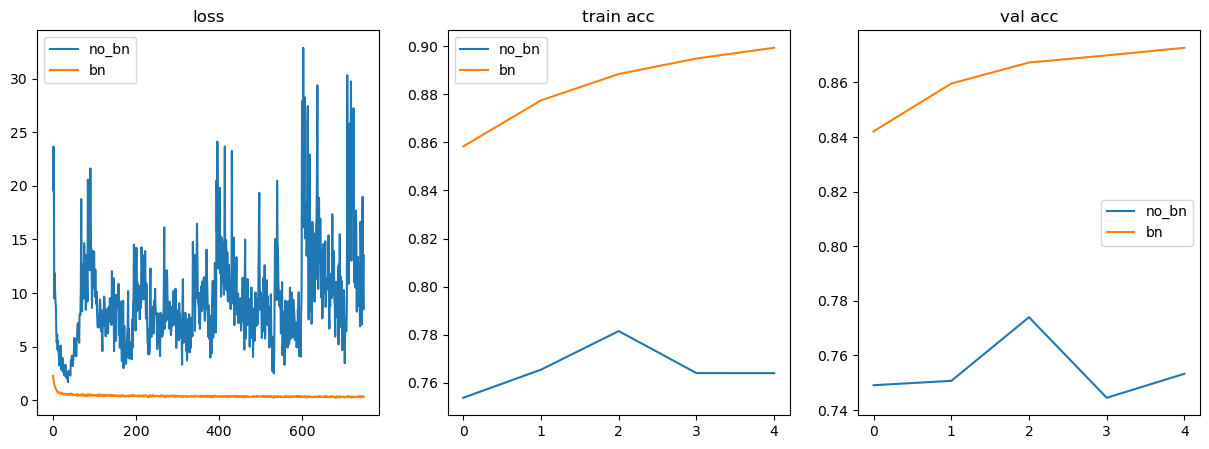

In [75]:
# Plot bn and no_bn results together in three plots and make a comparison. 
title_name = ["loss", "train acc", "val acc"]
_, axarr = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    axarr[i].plot(hist_shallow_no_bn[i], label="no_bn")
    axarr[i].plot(hist_shallow_bn[i], label="bn")
    axarr[i].legend(), axarr[i].set_title(title_name[i])
plt.show()

**Experiment on deep MLP** 

Here in the demo, we set a large learning rate on purpose. You can play with different learning rates and see what happens. 

In [78]:
# Build a deep 5-layer network without batch normalization. Remember to "use_bn".
use_bn = False
model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[100, 50, 50, 100], num_classes=10, 
    weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn
)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_deep_no_bn = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=5, batch_size=100, learning_rate=1e-2, learning_decay=0.95, 
    verbose=False, record_interval=4
)

number of batches for training: 600
epoch 1: valid acc = 0.1, new learning rate = 0.0095, number of evaluations 602
epoch 2: valid acc = 0.1, new learning rate = 0.009025, number of evaluations 602
epoch 3: valid acc = 0.1, new learning rate = 0.00857375, number of evaluations 602
epoch 4: valid acc = 0.1, new learning rate = 0.0081450625, number of evaluations 602
epoch 5: valid acc = 0.1, new learning rate = 0.007737809374999999, number of evaluations 602


In [77]:
# Build a deep 5-layer network with batch normalization. Remember to "use_bn".
use_bn = True
model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[100, 50, 50, 100], num_classes=10, 
    weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn
)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_deep_bn = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=5, batch_size=100, learning_rate=1e-2, learning_decay=0.95, 
    verbose=False, record_interval=4
)

number of batches for training: 600
epoch 1: valid acc = 0.7754, new learning rate = 0.0095, number of evaluations 602
epoch 2: valid acc = 0.8119, new learning rate = 0.009025, number of evaluations 602
epoch 3: valid acc = 0.8332, new learning rate = 0.00857375, number of evaluations 602
epoch 4: valid acc = 0.8449, new learning rate = 0.0081450625, number of evaluations 602
epoch 5: valid acc = 0.8488, new learning rate = 0.007737809374999999, number of evaluations 602


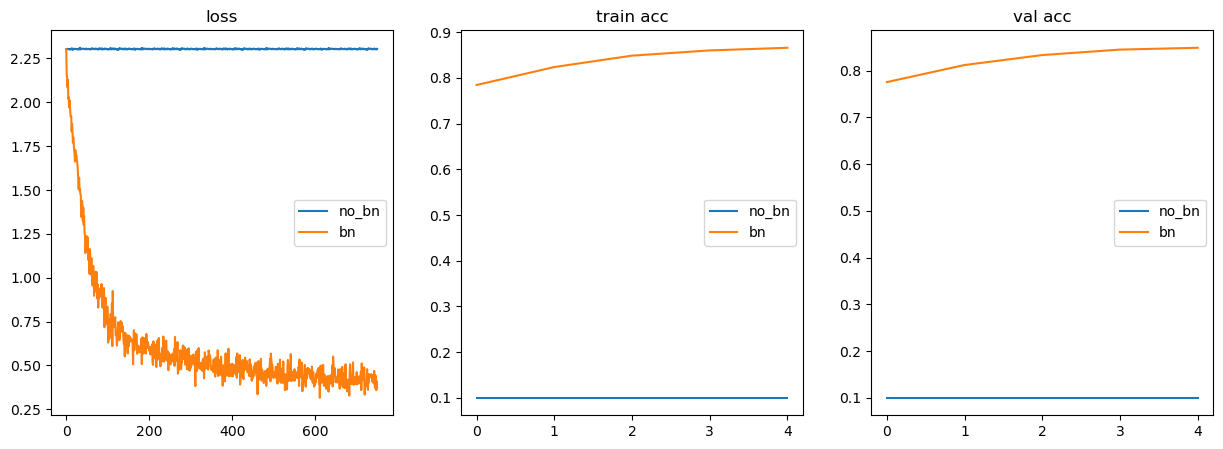

In [79]:
# Plot bn and no_bn results together in three plots and make a comparison. 
title_name = ["loss", "train acc", "val acc"]
_, axarr = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    axarr[i].plot(hist_deep_no_bn[i], label="no_bn")
    axarr[i].plot(hist_deep_bn[i], label="bn")
    axarr[i].legend(), axarr[i].set_title(title_name[i])
plt.show()

<span style="color:red"><strong>TODO:</strong></span> Describe what you find in this experiment.

Answer: **The experiment demonstrates the benefits of batch normalization in neural networks. Using batch normalization appears to improve convergence, reduce training loss, and achieve better training and validation accuracy compared to not using it. Batch normalization seems to make the model more robust, potentially stabilizing the learning process.**

## Part 2: Dropout (5%)

Dropout is another straightforward regularization technique that uses randomness to enforce the learning on all hidden neurons.

### Training Stage

During the forward pass of dropout, each entry in the original data are kept with a certain probability $p$, otherwise they are discarded (set to zero). Assume the input $X \in R^{N \times D}$, the forward pass is

$$Y = M \odot X \in R^{N \times D}$$

where $M \sim B(N \times D, p)$ is a boolean mask generated from Binomial distribution.

### Testing Stage

In the testing stage, randomness is no longer desired, but we still need to retain the mean and variance of the output so that it conforms with the training. Therefore, we use

$$Y = p X$$

### Implement dropout_forward function

<span style="color:red"><strong>TODO:</strong></span> Edit function `dropout_forward` in `./utils/reg_funcs.py`. If the code is running correctly, you will see that the outputs of the verification code should be close to each other. 

If the function is correct, then **the output mean should be close to the input mean. Input mean and output test mean should be identical.**

In [80]:
################################################
# Checking/verification code. Don't change it. #
################################################
from utils.reg_funcs import dropout_forward
from utils.reg_funcs import dropout_backward

x_in = np.random.randn(500, 500) + 10

p = 0.7
dropout_config = {"enabled": True, "keep_prob": p}
# feedforward
out, cache = dropout_forward(x=x_in, dropout_config=dropout_config, mode="train")
out_test, _ = dropout_forward(x=x_in, dropout_config=dropout_config, mode="test") 
# backward
dout = np.ones_like(x_in)
dx = dropout_backward(dout, cache)
################################################
# Checking/verification code. Don't change it. #
################################################
# Check forward correctness
print("mean_of_input = {}".format(p*np.mean(x_in)))
print("mean_of_out = {}".format(np.mean(out)))
print("mean_of_out_test = {}".format(np.mean(out_test)))

mean_of_input = 6.998959719354249
mean_of_out = 7.000184689630285
mean_of_out_test = 6.998959719354248


### Dropout Experiments with MLP

<span style="color:red"><strong>TODO:</strong></span>

1. Add dropout into the MLP in `./utils/neuralnets/mlp.py` and understand how the dropout is added into the MLP.

2. Customize your own MLP network. Then, train networks with different $p$ of $\{0.1, 0.3, 0.5, 0.7, 0.9, 1\}$. If $p = 1$, then the network is equivalent to the MLP without dropout. 

3. Plot the loss, training accuracy, and validation accuracy curves.

Note that checking/validation code is included below with preselected dropout parameters.

In [81]:
# Here is an example on how to collect loss and accuracy info
dropout_config = {"enabled": True, "keep_prob": 1}
model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
    weight_scale=1e-3, l2_reg=0.0, dropout_config=dropout_config
)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_no_dropout = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=5, batch_size=100, learning_rate=1e-4, learning_decay=0.95, 
    verbose=False, record_interval=4
)

number of batches for training: 600
epoch 1: valid acc = 0.8525, new learning rate = 9.5e-05, number of evaluations 602
epoch 2: valid acc = 0.865, new learning rate = 9.025e-05, number of evaluations 602
epoch 3: valid acc = 0.8702, new learning rate = 8.573749999999999e-05, number of evaluations 602
epoch 4: valid acc = 0.8742, new learning rate = 8.145062499999998e-05, number of evaluations 602
epoch 5: valid acc = 0.8783, new learning rate = 7.737809374999998e-05, number of evaluations 602


In [82]:
dropout_config = {"enabled": True, "keep_prob": 0.9}
model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
    weight_scale=1e-3, l2_reg=0.0, dropout_config=dropout_config
)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_dropout_1 = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=5, batch_size=100, learning_rate=1e-4, learning_decay=0.95, 
    verbose=False, record_interval=4
)

number of batches for training: 600
epoch 1: valid acc = 0.8518, new learning rate = 9.5e-05, number of evaluations 602
epoch 2: valid acc = 0.8663, new learning rate = 9.025e-05, number of evaluations 602
epoch 3: valid acc = 0.8709, new learning rate = 8.573749999999999e-05, number of evaluations 602
epoch 4: valid acc = 0.8742, new learning rate = 8.145062499999998e-05, number of evaluations 602
epoch 5: valid acc = 0.8741, new learning rate = 7.737809374999998e-05, number of evaluations 602


In [83]:
dropout_config = {"enabled":True, "keep_prob": 0.7}
model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
    weight_scale=1e-3, l2_reg=0.0, dropout_config=dropout_config
)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_dropout_2 = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=5, batch_size=100, learning_rate=1e-4, learning_decay=0.95, 
    verbose=False, record_interval=4
)

number of batches for training: 600
epoch 1: valid acc = 0.8422, new learning rate = 9.5e-05, number of evaluations 602
epoch 2: valid acc = 0.8551, new learning rate = 9.025e-05, number of evaluations 602
epoch 3: valid acc = 0.862, new learning rate = 8.573749999999999e-05, number of evaluations 602
epoch 4: valid acc = 0.8642, new learning rate = 8.145062499999998e-05, number of evaluations 602
epoch 5: valid acc = 0.871, new learning rate = 7.737809374999998e-05, number of evaluations 602


In [84]:
dropout_config = {"enabled":True, "keep_prob": 0.5}
model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
    weight_scale=1e-3, l2_reg=0.0, dropout_config=dropout_config
)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_dropout_3 = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=5, batch_size=100, learning_rate=1e-4, learning_decay=0.95, 
    verbose=False, record_interval=4
)

number of batches for training: 600
epoch 1: valid acc = 0.828, new learning rate = 9.5e-05, number of evaluations 602
epoch 2: valid acc = 0.8427, new learning rate = 9.025e-05, number of evaluations 602
epoch 3: valid acc = 0.853, new learning rate = 8.573749999999999e-05, number of evaluations 602
epoch 4: valid acc = 0.8545, new learning rate = 8.145062499999998e-05, number of evaluations 602
epoch 5: valid acc = 0.8567, new learning rate = 7.737809374999998e-05, number of evaluations 602


In [85]:
dropout_config = {"enabled":True, "keep_prob": 0.3}
model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
    weight_scale=1e-3, l2_reg=0.0, dropout_config=dropout_config
)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_dropout_4 = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=5, batch_size=100, learning_rate=1e-4, learning_decay=0.95, 
    verbose=False, record_interval=4
)

number of batches for training: 600
epoch 1: valid acc = 0.8049, new learning rate = 9.5e-05, number of evaluations 602
epoch 2: valid acc = 0.8249, new learning rate = 9.025e-05, number of evaluations 602
epoch 3: valid acc = 0.8297, new learning rate = 8.573749999999999e-05, number of evaluations 602
epoch 4: valid acc = 0.8363, new learning rate = 8.145062499999998e-05, number of evaluations 602
epoch 5: valid acc = 0.8378, new learning rate = 7.737809374999998e-05, number of evaluations 602


In [87]:
dropout_config = {"enabled":True, "keep_prob": 0.1}
model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
    weight_scale=1e-3, l2_reg=0.0, dropout_config=dropout_config
)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_dropout_5 = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=5, batch_size=100, learning_rate=1e-4, learning_decay=0.95, 
    verbose=False, record_interval=4
)

number of batches for training: 600
epoch 1: valid acc = 0.6975, new learning rate = 9.5e-05, number of evaluations 602
epoch 2: valid acc = 0.7354, new learning rate = 9.025e-05, number of evaluations 602
epoch 3: valid acc = 0.7466, new learning rate = 8.573749999999999e-05, number of evaluations 602
epoch 4: valid acc = 0.7542, new learning rate = 8.145062499999998e-05, number of evaluations 602
epoch 5: valid acc = 0.7613, new learning rate = 7.737809374999998e-05, number of evaluations 602


In [89]:
loss_no_dropout, train_acc_no_dropout, val_acc_no_dropout = hist_no_dropout
loss_dropout_1, train_acc_dropout_1, val_acc_dropout_1 = hist_dropout_1
loss_dropout_2, train_acc_dropout_2, val_acc_dropout_2 = hist_dropout_2
loss_dropout_3, train_acc_dropout_3, val_acc_dropout_3 = hist_dropout_3
loss_dropout_4, train_acc_dropout_4, val_acc_dropout_4 = hist_dropout_4
loss_dropout_5, train_acc_dropout_5, val_acc_dropout_5 = hist_dropout_5

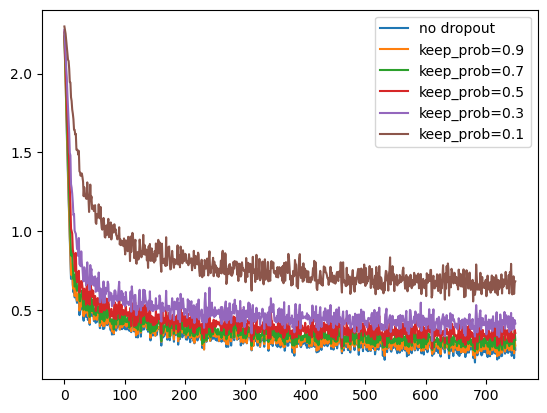

In [90]:
plt.plot(loss_no_dropout, label="no dropout")
plt.plot(loss_dropout_1, label="keep_prob=0.9")
plt.plot(loss_dropout_2, label="keep_prob=0.7")
plt.plot(loss_dropout_3, label="keep_prob=0.5")
plt.plot(loss_dropout_4, label="keep_prob=0.3")
plt.plot(loss_dropout_5, label="keep_prob=0.1")
plt.legend()
plt.show()

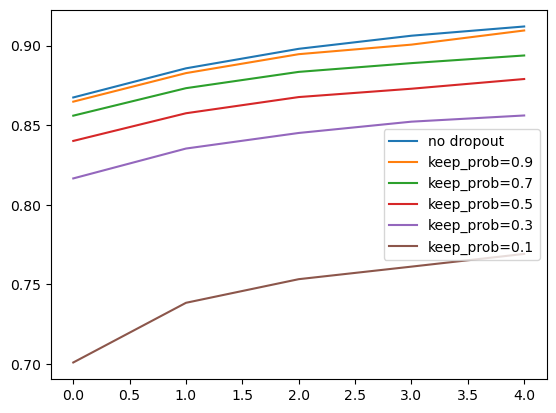

In [91]:
plt.plot(train_acc_no_dropout, label="no dropout")
plt.plot(train_acc_dropout_1, label="keep_prob=0.9")
plt.plot(train_acc_dropout_2, label="keep_prob=0.7")
plt.plot(train_acc_dropout_3, label="keep_prob=0.5")
plt.plot(train_acc_dropout_4, label="keep_prob=0.3")
plt.plot(train_acc_dropout_5, label="keep_prob=0.1")
plt.legend()
plt.show()

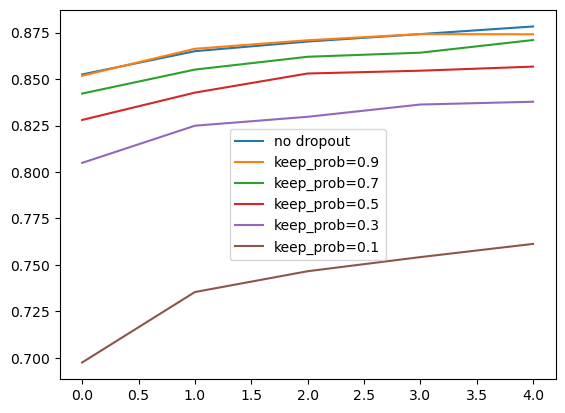

In [92]:
plt.plot(val_acc_no_dropout, label="no dropout")
plt.plot(val_acc_dropout_1, label="keep_prob=0.9")
plt.plot(val_acc_dropout_2, label="keep_prob=0.7")
plt.plot(val_acc_dropout_3, label="keep_prob=0.5")
plt.plot(val_acc_dropout_4, label="keep_prob=0.3")
plt.plot(val_acc_dropout_5, label="keep_prob=0.1")
plt.legend()
plt.show()

<span style="color:red"><strong>TODO:</strong></span> Describe what you find in this dropout experiment.

Answer: **The experiment emphasizes the importance of dropout as a regularization technique to prevent overfitting. Moderate dropout values like 0.5 and 0.7 seem to strike a balance between preventing overfitting and allowing the model to learn effectively. Too little dropout (as in the 'no dropout' case) can lead to overfitting, while too much dropout (e.g., keep_prob=0.1) can lead to underfitting.**

## Part 3: Dropout + Batch Normalization (5%)

In [93]:
# Create a deep network with both dropout and batch normalization.
dropout_config = {"enabled": True, "keep_prob": 0.9}
use_bn = True
model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[128, 64, 32], num_classes=10, 
    weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn, dropout_config=dropout_config
)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_dropout_5 = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=5, batch_size=100, learning_rate=1e-4, learning_decay=0.95, 
    verbose=False, record_interval=4
)

number of batches for training: 600
epoch 1: valid acc = 0.1798, new learning rate = 9.5e-05, number of evaluations 602
epoch 2: valid acc = 0.184, new learning rate = 9.025e-05, number of evaluations 602
epoch 3: valid acc = 0.1878, new learning rate = 8.573749999999999e-05, number of evaluations 602
epoch 4: valid acc = 0.1909, new learning rate = 8.145062499999998e-05, number of evaluations 602
epoch 5: valid acc = 0.1925, new learning rate = 7.737809374999998e-05, number of evaluations 602
